In [19]:
!pip install -q kaggle torch torchvision matplotlib opencv-python


In [20]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [21]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product
!unzip real-life-industrial-dataset-of-casting-product -d casting_data

Streaming output truncated to the last 5000 lines.
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: casting_data/casting_data/cas

In [22]:
import os
import torch
import torchvision
import numpy as np
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image


In [23]:
import os
#print(os.listdir(root_dir))

In [24]:
#print(os.listdir(os.path.join(root_dir, "casting_data/casting_data/train/def_front/")))


In [25]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CastingDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Define paths
        defective_path = os.path.join(root_dir, "casting_data/casting_data/train/def_front/")
        ok_path = os.path.join(root_dir, "casting_data/casting_data/train/ok_front/")

        # Collect images from both folders
        defective_imgs = sorted(os.listdir(defective_path))
        ok_imgs = sorted(os.listdir(ok_path))

        # Store full paths
        self.imgs = [os.path.join(defective_path, img) for img in defective_imgs] + \
                    [os.path.join(ok_path, img) for img in ok_imgs]

        # Corresponding labels (1 = defective, 0 = ok)
        self.labels = [1] * len(defective_imgs) + [0] * len(ok_imgs)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Generate synthetic bounding boxes (since dataset lacks annotations)
        width, height = image.size
        boxes = torch.tensor([[10, 10, width - 10, height - 10]], dtype=torch.float32)  # Entire image as bounding box
        labels = torch.tensor([label], dtype=torch.int64)  # Label (1 = defective, 0 = ok)

        # Convert to target format
        target = {"boxes": boxes, "labels": labels}

        # Apply transforms if available
        if self.transforms:
            image = self.transforms(image)

        return image, target  # ✅ Return image and dictionary

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images (optional)
    transforms.ToTensor(),
])

# Load Dataset
dataset = CastingDataset(root_dir="casting_data", transforms=transform)

#get the list of image & targets
def collate_fn(batch):
    images = []
    targets = []

    for image, target in batch:
        images.append(image)   # Append images directly
        targets.append(target) # Append target dictionaries directly

    return images, targets  # ✅ Returns lists directly
# Create DataLoader
#data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True,
                         collate_fn=collate_fn, num_workers=2, pin_memory=True)



# Check dataset loading
for images, targets in data_loader:
    print(f"Batch size: {len(images)}")
    print(f"Example target: {targets[0]}")  # Print target dictionary
    break  # Print only first batch


Batch size: 4
Example target: {'boxes': tensor([[ 10.,  10., 290., 290.]]), 'labels': tensor([1])}


In [26]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load Faster R-CNN Pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to detect casting defects (2 classes: defective, background)
num_classes = 2  # 1 (Defective) + Background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer & learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [28]:
#import torch

#print(torch.cuda.is_available())   # Should return True
#print(torch.cuda.current_device()) # Should return 0 (if GPU is available)
#print(torch.cuda.get_device_name(0)) # Should print GPU name


In [29]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    lr_scheduler.step()

print("Training Complete!")


Epoch [1/1], Loss: 12.9974
Training Complete!


In [30]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Ensure model is in evaluation mode
model.eval()

# Lists to store predictions and actual labels
all_preds = []
all_labels = []

# Loop through test dataset
with torch.no_grad():
    for images, targets in data_loader:  # Assuming same loader for testing
        images = [img.to(device) for img in images]

        # Get predictions
        outputs = model(images)

        for output, target in zip(outputs, targets):
            # Ground truth label
            true_label = target["labels"].item()
            all_labels.append(true_label)

            # If any object is detected (bounding box present), classify as Defective (1)
            if len(output["boxes"]) > 0 and output["scores"][0] > 0.5:  # Threshold 0.5
                pred_label = 1  # Defective
            else:
                pred_label = 0  # OK (No defect detected)

            all_preds.append(pred_label)

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


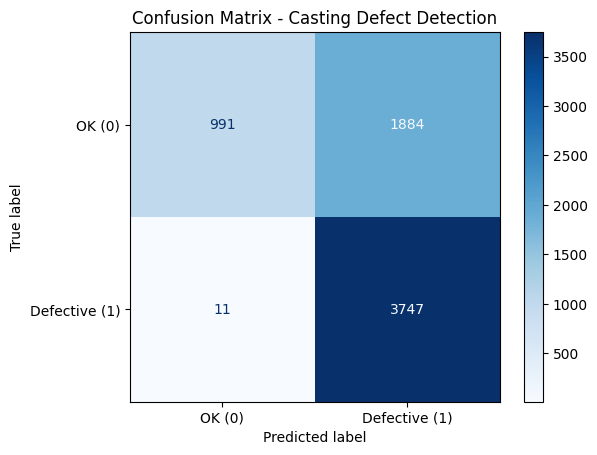

In [31]:
# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["OK (0)", "Defective (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Casting Defect Detection")
plt.show()


In [32]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["OK", "Defective"]))


Classification Report:
              precision    recall  f1-score   support

          OK       0.99      0.34      0.51      2875
   Defective       0.67      1.00      0.80      3758

    accuracy                           0.71      6633
   macro avg       0.83      0.67      0.65      6633
weighted avg       0.81      0.71      0.67      6633



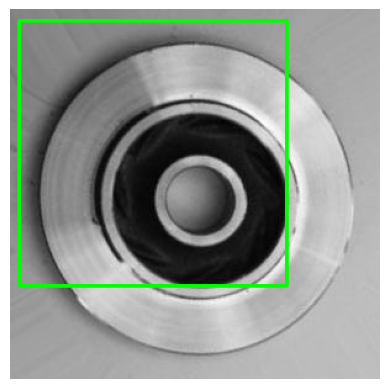

In [33]:
#test on one defect image

model.eval()
img_path = "casting_data/casting_data/casting_data/train/def_front/cast_def_0_9150.jpeg"

img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# Run Inference
with torch.no_grad():
    prediction = model(img_tensor)

# Visualizing the result
img_np = np.array(img)
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

for i, box in enumerate(boxes):
    if scores[i] > 0.5:  # Confidence Threshold
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(img_np, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

plt.imshow(img_np)
plt.axis("off")
plt.show()
